In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge, Input

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## prepare data

In [2]:
def double_integrate(df, col):
    df.sort_values(by='t', inplace=True)
    velocities = df[col].cumsum()
    positions = velocities.cumsum()
    return positions
# load data
def load_data_time(directory = 'data/group3/config_1', all_data=[], labels=[]):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        data = pd.read_csv(f)
        data['pos_x'] = double_integrate(data,'raw_acceleration_x')
        data['pos_y'] = double_integrate(data,'raw_acceleration_y')
        data['pos_z'] = double_integrate(data,'raw_acceleration_z')
        all_data.append(np.array(data))
        # formatage des labels pour chaque pas de temps
        if directory == 'data/h_config1-lcb':
            _label = int(filename[2])
        elif directory == 'data/v_config1-lcb':
            _label = int(filename[10])
        elif directory == 'data/groupe1_groupe2':
            _label = int(filename.split('_')[1])
        else :
            _label = int(filename[0])
        labels.append(np.array([_label]*len(data)).reshape(-1,1))
    columns_name = pd.read_csv(os.path.join(directory, os.listdir(directory)[1])).columns.tolist()
    return all_data, labels, columns_name

# load horizontal
all_data, labels, _ = load_data_time()
# # print(len(all_data))
# all_data, labels, _ = load_data_time('data/h_config1-lcb',all_data,labels)
# print(len(all_data))
# # load vertical
# all_data, labels, _ = load_data_time('data/v_config1-lcb',all_data,labels)
# print(len(all_data))
# # load 3D
# all_data, labels, _ = load_data_time('data/groupe1_groupe2',all_data,labels)
# print(len(all_data))

#### process label 
* we need one hot encoded matrice for classification with reservoirpy
* we need a class for each time_step
* we process before the train_test_split for convenience

In [3]:
enc = OneHotEncoder()
enc.fit_transform(np.array(np.arange(10).reshape(-1,1)))

new_label=[]
for i in range(len(all_data)):
    new_label.append(enc.transform(labels[i]).toarray())#np.tile(enc.transform(labels[i]), (len(all_data[i]), 1)))
print("On transforme les label en one hot encoded:\n",new_label[0][:10])

On transforme les label en one hot encoded:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


#### train_test_split
* on ne peut pas utiliser sklearn
* train test split with balnaced classes

In [4]:
def train_test_split(all_data, labels, seed_=42):
    np.random.seed(seed_)
    idx_per_class={}
    for i, target in enumerate(labels):
        for j in range(10):
            if j == int(target[0][0]):
                if j not in idx_per_class:
                    idx_per_class[j] = str(i)
                else:
                    idx_per_class[j] = str(idx_per_class[j])+'-'+str(i)

    idx_test=[]
    for t_ in idx_per_class.keys():
        list_idx = idx_per_class[t_].split('-')
        n_test = len(list_idx)//4  # 25% dans le test
        idx_test.append(np.random.choice(list_idx, n_test))

    idx_test = np.concatenate(idx_test).astype(int)
    idx_train = np.array( list(set(np.arange(len(all_data))) - set(idx_test))).astype(int)

    X_train, X_test = [all_data[i] for i in idx_train],  [all_data[i] for i in idx_test] 
    y_train, y_test = [new_label[i] for i in idx_train],  [new_label[i] for i in idx_test]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(all_data, labels, seed_=42)


# reservoir coomputing (the simpliest model)
* https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/5-Classification-with-RC.ipynb


   * lr: the leaking rate, which controls the time constant of the neurons;
   * sr: the spectral radius of the recurrent connections in the reservoir. It controls the chaoticity of the reservoir dynamics.

#### run the model


In [5]:
# on initialize reservoirpy
rpy.verbosity(0) 
rpy.set_seed(42) 

# Simpliest ESN model 
# https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/1-Getting_Started.ipynb
reservoir = Reservoir(500, lr=0.1, sr=0.9)
ridge = Ridge(ridge=1e-6)
esn_model = reservoir >> ridge


# fit & predict
esn_model = esn_model.fit(X_train, y_train, warmup=10)
print("reservoir initialize, ")
print(reservoir.is_initialized, ridge.is_initialized, ridge.fitted)
Y_pred = esn_model.run(X_test)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### decode predictions

In [6]:
def make_binary(arr):
    mask = np.zeros(arr.shape)
    mask[np.argmax(arr)] = 1
    return mask

preds = [[make_binary(b) for b in a] for a in Y_pred]

##### on choisi la classe qui à été le plus souvent trouvée

In [8]:
def most_occuring_pred(arr):
    idx = np.argmax(sum(arr))
    mask = np.zeros(arr[0].shape)
    mask[idx] = 1
    mask = mask.reshape(1, -1)
    return enc.inverse_transform(mask)[0]

label_y_pred = [most_occuring_pred([make_binary(b) for b in a]) for a in Y_pred] 
label_y_test = [most_occuring_pred(a) for a in y_test] 

##### on peut visualiser l'evolution des predictions en fonction des timestep

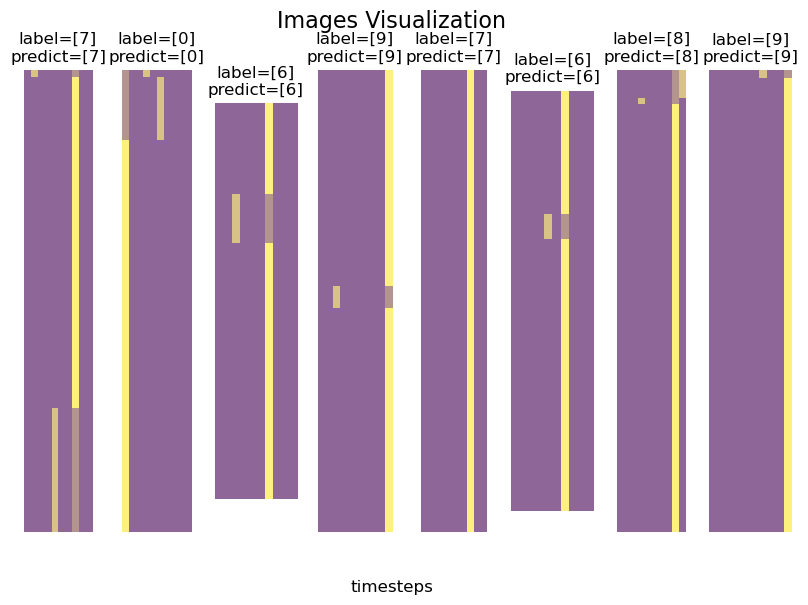

In [9]:
fig, ax = plt.subplots(1, 8, figsize=(10, 6))  
for i, n in enumerate(np.random.choice(len(y_test), 8, replace=False)):
    ax[i].imshow(preds[n],alpha=0.5)#,cmap='jet')
    ax[i].imshow(y_test[n],alpha=0.2)#, cmap='jet')
    #ax[i].imshow(Y_pred[n],alpha=0.5,cmap='jet')
    ax[i].axis('off') 
    ax[i].set_title(f"label={label_y_test[n]}\npredict={label_y_pred[n]}")
fig.suptitle("Images Visualization", fontsize=16)
fig.text(0.5, 0.01, 'timesteps', ha='center', fontsize=12)
plt.show()


accuracy ...  0.8653846153846154
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.60      1.00      0.75         6
           3       1.00      1.00      1.00         4
           4       1.00      0.80      0.89         5
           5       0.50      0.40      0.44         5
           6       1.00      0.60      0.75         5
           7       0.86      1.00      0.92         6
           8       1.00      1.00      1.00         6
           9       1.00      0.80      0.89         5

    accuracy                           0.87        52
   macro avg       0.90      0.86      0.86        52
weighted avg       0.89      0.87      0.86        52



Text(0.5, 1.0, 'Table de contingence')

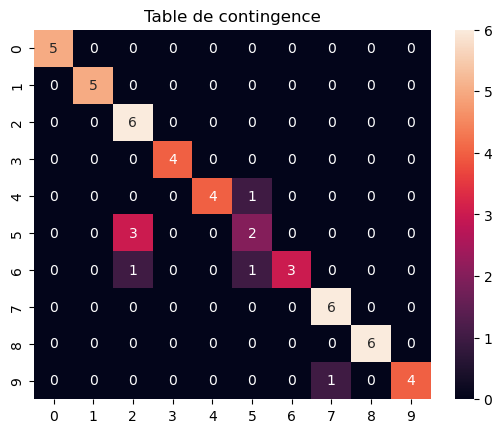

In [10]:
print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(label_y_test,label_y_pred))
sns.heatmap(confusion_matrix(label_y_test,label_y_pred), fmt=".2g", annot=True)
plt.title("Table de contingence")

#### methodes tutoriel - accuracy pour chaque pas de temps

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.61529e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


accuracy ...  0.8653846153846154
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       332
           1       0.87      0.98      0.92       264
           2       0.75      0.73      0.74       371
           3       0.88      0.84      0.86       267
           4       0.83      0.83      0.83       328
           5       0.80      0.44      0.57       373
           6       0.77      0.77      0.77       285
           7       0.86      0.91      0.89       409
           8       0.78      0.97      0.87       593
           9       0.94      0.74      0.82       319

    accuracy                           0.83      3541
   macro avg       0.83      0.82      0.82      3541
weighted avg       0.83      0.83      0.82      3541



<Axes: >

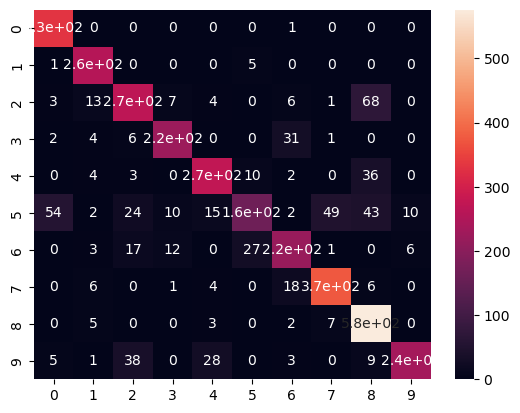

In [11]:
# Transduction (sequence-to-sequence model)
source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)
model = [source >> reservoir, source] >> readout

# fit & predict
Y_pred = model.fit(X_train, y_train, stateful=False, warmup=2).run(X_test, stateful=False)

# decode output
# There are 9 variables(speakers), hence the output space is 9-dimensional. The variable(speaker) label is the index of the output neuron with maximum activation.
Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t, axis=1) for y_t in y_test]

score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))

# print("Accuracy: ", f"{score * 100:.3f} %")

print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0)))
sns.heatmap(confusion_matrix(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0)), fmt=".2g", annot=True)

accuracy ...  0.9230769230769231
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      1.00      1.00         5
           2       0.83      0.83      0.83         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5
           5       1.00      0.60      0.75         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         6
           8       0.86      1.00      0.92         6
           9       1.00      0.80      0.89         5

    accuracy                           0.92        52
   macro avg       0.94      0.92      0.92        52
weighted avg       0.94      0.92      0.92        52



<Axes: >

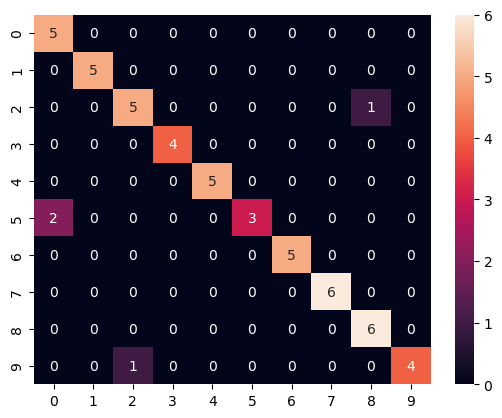

In [12]:
label_y_pred = [most_occuring_pred([make_binary(b) for b in a]) for a in Y_pred] 
label_y_test = [most_occuring_pred(a) for a in y_test] 

print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(label_y_test,label_y_pred))
sns.heatmap(confusion_matrix(label_y_test,label_y_pred), fmt=".2g", annot=True)

source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)

model = source >> reservoir >> readout

In [28]:
from reservoirpy.nodes import Reservoir, Ridge, Input
import time

def explore_hyperparams(param_name='neurons', params_range=[50, 100, 200, 300, 500, 800, 1000, 2000, 3000]):
    results = []
    for param_ in params_range:
        
        source = Input()
        if param_name == 'neurons':
            reservoir = Reservoir(param_, sr=0.9, lr=0.1)
        elif param_name == 'sr':
            reservoir = Reservoir(500, sr=param_, lr=0.1)
        elif param_name == 'lr':
            reservoir = Reservoir(500, sr=0.9, lr=param_)
        else:
            reservoir = Reservoir(500, sr=0.9, lr=0.1)

        readout = Ridge(ridge=1e-6)

        model = [source >> reservoir, source] >> readout   # modele 2 connecte 

        # fit
        t0=time.time()
        model = model.fit(X_train, y_train, stateful=False, warmup=2)
        time_fit = time.time() - t0

        # pred
        Y_pred = model.run(X_test, stateful=False)
        time_pred = time.time()-t0-time_fit
        Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
        Y_test_class = [np.argmax(y_t, axis=1) for y_t in y_test]

        #train score
        Y_pred_train = model.run(X_train, stateful=False)
        Y_pred_train_class = [np.argmax(y_p, axis=1) for y_p in Y_pred_train]
        Y_train_class = [np.argmax(y_t, axis=1) for y_t in y_train]

        score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))
        score_train = accuracy_score(np.concatenate(Y_train_class, axis=0), np.concatenate(Y_pred_train_class, axis=0))
        results.append([param_,score,score_train,time_fit,time_pred])
    return results


results = explore_hyperparams(param_name = 'neurons', params_range = [50, 100, 200, 300, 500, 800, 1000, 2000, 3000])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.7807e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.71552e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.83634e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.51256e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.44204e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.09432e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.23305e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.35773e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.82863e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Text(0.5, 1.0, 'INfluence du nombre de neuronnes dans le réservoir')

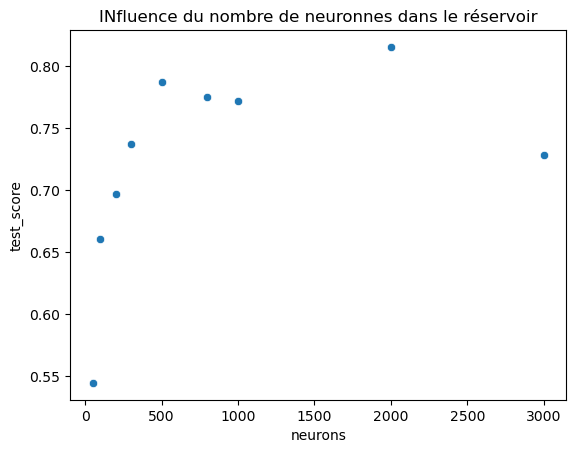

In [29]:
res_ = pd.DataFrame(results, columns=['neurons','test_score','score_train','fit_time','pred_time'])

import seaborn as sns
sns.scatterplot(data=res_,x='neurons',y='test_score')
sns.scatterplot(data=res_,x='neurons',y='train_score')
plt.title('INfluence du nombre de neuronnes dans le réservoir')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.20035e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.81253e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.19936e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.26814e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.49931e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.46613e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.57259e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.34177e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.43467e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.38419e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Text(0.5, 1.0, 'INfluence du nombre de neuronnes dans le réservoir')

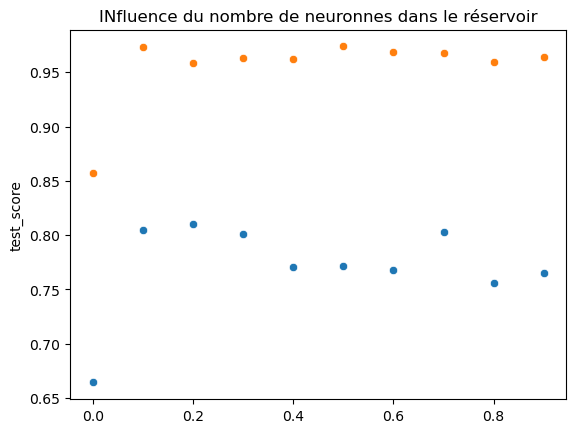

In [30]:
results = explore_hyperparams(param_name = 'sr', params_range = np.arange(10)*0.1)

res_ = pd.DataFrame(results, columns=['sr','test_score','score_train','fit_time','pred_time'])

import seaborn as sns
sns.scatterplot(data=res_,x='sr',y='test_score')
sns.scatterplot(data=res_,x='sr',y='score_train')
plt.title('Influence du sr')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.98146e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.56038e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.64291e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.47096e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Text(0.5, 1.0, 'INfluence du nombre de neuronnes dans le réservoir')

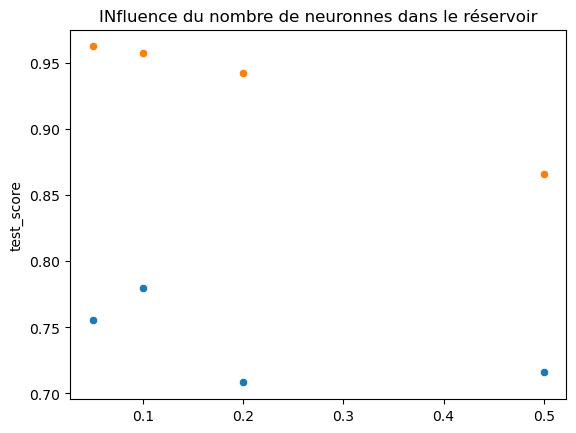

In [31]:
results = explore_hyperparams(param_name = 'lr', params_range =[0.05,0.1,0.2,0.5])

res_ = pd.DataFrame(results, columns=['lr','test_score','score_train','fit_time','pred_time'])

import seaborn as sns
sns.scatterplot(data=res_,x='lr',y='test_score')
sns.scatterplot(data=res_,x='lr',y='score_train')
plt.title('Influence du lr')

In [ ]:
np.arange(10)*0.1

## deep models

In [ ]:
#Hierarchical ESN 
reservoir1 = Reservoir(100, name="res1_1")
reservoir2 = Reservoir(100, name="res2_1")

readout1 = Ridge(ridge=1e-5, name="readout1_1")
readout2 = Ridge(ridge=1e-5, name="readout2_1")

model = reservoir1 >> readout1 >> reservoir2 >> readout2

model = model.fit(X_train, {"readout1-1": y_train, "readout2-1": y_train})

ValueError: Missing target data for node readout1_1.

In [ ]:
#Deep ESN
reservoir1 = Reservoir(100, name="res1-2")
reservoir2 = Reservoir(100, name="res2-2")
reservoir3 = Reservoir(100, name="res3-2")

readout = Ridge(name="readout-2")

model = reservoir1 >> reservoir2 >> reservoir3 & \
        data >> [reservoir1, reservoir2, reservoir3] >> readout

In [ ]:
#Multi input
reservoir1 = Reservoir(100, name="res1-3")
reservoir2 = Reservoir(100, name="res2-3")
reservoir3 = Reservoir(100, name="res3-3")

readout1 = Ridge(name="readout2")
readout2 = Ridge(name="readout1")

model = [reservoir1, reservoir2] >> readout1 & \
        [reservoir2, reservoir3] >> readout2